# Image Processing Application #1: Color Quantization

In [1]:
import time
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

First, let's load in an image of Theo Ignatius Litovsky-Tralie (TILT)

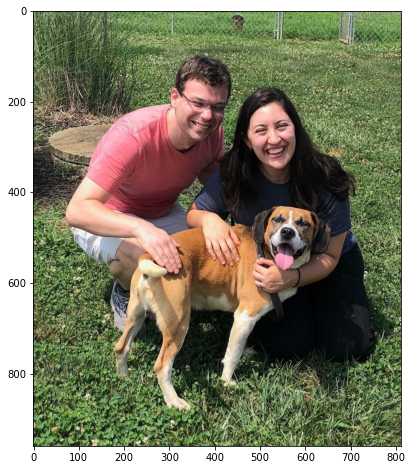

In [2]:
I = skimage.io.imread("theo.jpg")/255
plt.figure(figsize=(8, 8))
plt.imshow(I)

Every pixel has 3 coordinates: red, green, and blue.  We'll treat every pixel as a data point in 3D and reshape into a data matrix so that, as usual, each individual data point is a row in this matrix, and red, green, and blue are columns.

In [3]:
shape = I.shape
print("Shape before:", shape)
X = np.reshape(I, (shape[0]*shape[1], shape[2]))
print("Shape after", X.shape)

Shape before: (960, 812, 3)
Shape after (779520, 3)


Let's actually plot these as a point cloud.  We'll plot all pairs of 2 coordinates against each other

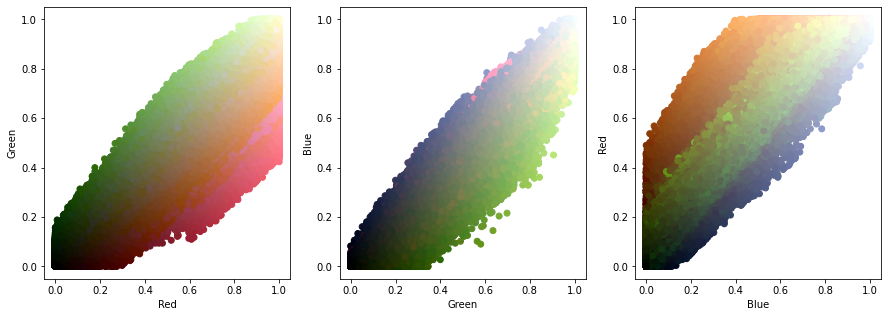

In [4]:
channels = ["Red", "Green", "Blue"]
plt.figure(figsize=(15, 5))
for k in range(3):
    j = (k+1)%3
    plt.subplot(1, 3, k+1)
    plt.scatter(X[:, k], X[:, j], c=X)
    plt.xlabel(channels[k])
    plt.ylabel(channels[j])

We can see that different shades of green from the grass are there, as well as Theo's orange, and the pink on my shirt, among other things.  It's pretty clear from these plots, though, that these colors are all in one blob in 3D.  Still, we can use KMeans here to find clusters.  Regardless of the distribution of points, KMeans will tend to find clusters that are spread out and compact, since it minimizes the sum of the squared distances to each cluster center.

Let's first use KMeans to find 16 cluster centers.  We'll cheat using the <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">KMeans method from scikit-learn</a>, though you'll have to implement your own version in the assignment.

In [5]:
kmeans = KMeans(n_clusters=16).fit(X)

Let's plot these cluster centers as we did the original point cloud

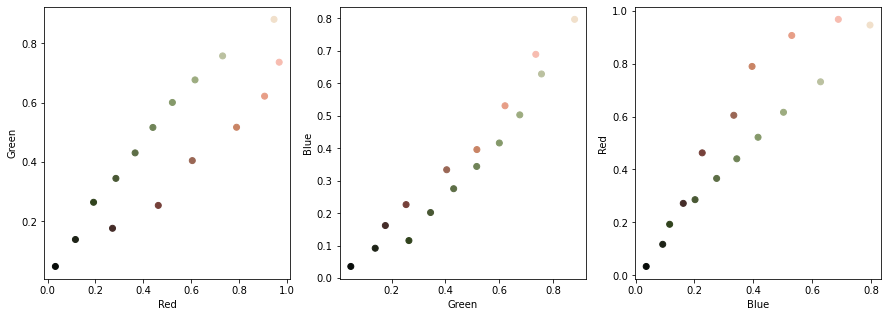

In [6]:
C = kmeans.cluster_centers_
plt.figure(figsize=(15, 5))
for k in range(3):
    j = (k+1)%3
    plt.subplot(1, 3, k+1)
    plt.scatter(C[:, k], C[:, j], c=C)
    plt.xlabel(channels[k])
    plt.ylabel(channels[j])

As promised, they are spread out pretty evenly throughout the dataset.  If we substitute the color of each pixel with the color of the center to which its assigned (the closest center above), we get the following image

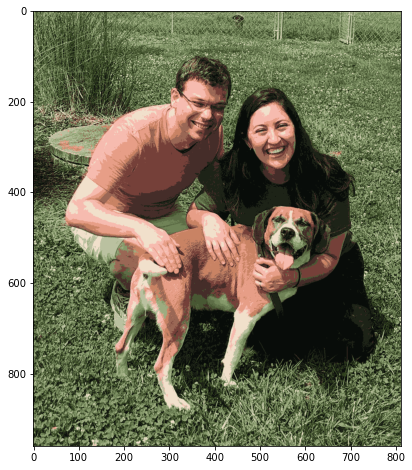

In [7]:
Y = kmeans.cluster_centers_[kmeans.labels_]
plt.figure(figsize=(8, 8))
plt.imshow(np.reshape(Y, I.shape))

What we've managed to achieve above is something referred to as "nonuniform quantization," and it's a form of compression.  In the original image, we had 3 channels, red green and blue, each with 8 bits, for a total of 24-bit color.  Here, we've reduced to 16 possible colors total, which is only 4 bits.  So we've compressed by a factor of 6, while still retaining a lot of the original color.  

Let's say we only used 4 colors instead, so we go down to 2 bits.  Then we get the following results

[[0.09936312 0.11624877 0.07368767]
 [0.54754175 0.57462621 0.40853356]
 [0.87854715 0.73300126 0.64262524]
 [0.34218409 0.35438419 0.2301493 ]]


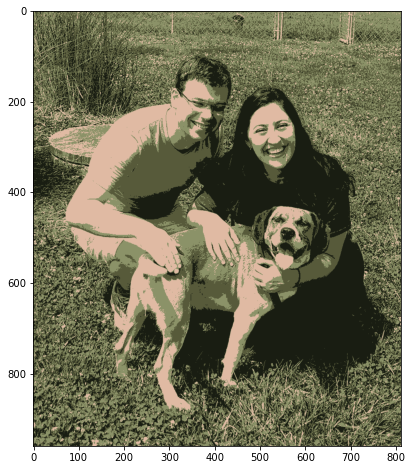

In [8]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
Y = kmeans.cluster_centers_[kmeans.labels_]
plt.figure(figsize=(8, 8))
plt.imshow(np.reshape(Y, I.shape))
print(kmeans.cluster_centers_)

Actually, at this point, we have the opportunity to do something artistic which you might recognize.  We can change the colors that we assign each cluster and then do the mapping again.  We'll use white, blue, red, and black to make it a big like the Obama campaign posters

0.0


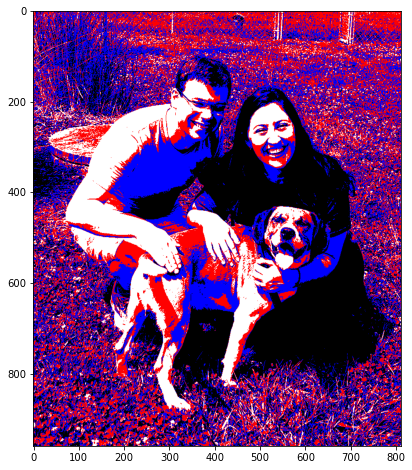

In [9]:
C = np.array([[0, 0, 0],  # White
              [1, 0, 0],  # Blue 
              [1, 1, 1],  # Red
              [0, 0, 1]], # Black 
              dtype=float)
Y = C[kmeans.labels_]
print(np.min(Y))
plt.figure(figsize=(8, 8))
plt.imshow(np.reshape(Y, I.shape))

# Image Processing Application #2: Superpixels

We can address a slightly different problem if we also include spatial information in the vectorization of each pixel.  

First, let's just create a data matrix where each row is a pixel but this time there are two columns: one for the x coordinate and one for the y coordinate of that pixel.  We're going to be using a lot more clusters, so we'll downscale and crop the image first to get a faster running time

(160, 110, 3)
(17600, 2)


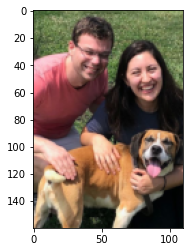

In [10]:
from skimage.transform import rescale
J = rescale(I, 0.25, multichannel=True, anti_aliasing=True)
J = J[20:180, 50:160, :]
print(J.shape)
plt.imshow(J)

N = max(J.shape[0], J.shape[1])
xx, yy = np.meshgrid(np.arange(J.shape[1])/N, np.arange(J.shape[0])/N)
X = np.array([xx.flatten(), yy.flatten()]).T
print(X.shape)

Let's do k-means clustering on these points, taking 900 clusters

In [11]:
tic = time.time()
kmeans = KMeans(init="k-means++", n_clusters=128, max_iter=30).fit(X)
print(time.time()-tic)

28.537397623062134


If we color each point by what cluster it was assigned to, we see that many of the clusters look like hexagons

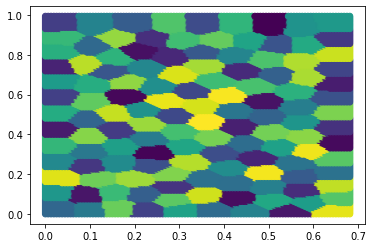

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)

The reason for this is <a href = "https://mathoverflow.net/questions/362135/does-the-plane-clustered-to-minimize-sum-distances2-to-clusters-centers-inert">quite deep</a>, but intuitively, KMeans is trying to find a minimum of the sum of the squared distances from the points in the dataset to the centers.  Points that concentrate inside of a ball (or a disc in 2D) minimize such distances.  However, if our points are equally spaced on the plane, we can't just fit a bunch of balls together and "tile" it.  The polygon with the most sides that can <a href = "https://en.wikipedia.org/wiki/Hexagonal_tiling">tile the plane is a regular hexagon</a>, so that ends up being the best option

Now let's combine what we've already done with the colors and go up to a 5D vector for each state, where the first 3 dimensions are red, green, and blue, and the last two dimensions are the X and Y coordinates

In [13]:
X2 = np.concatenate((X, np.reshape(J, (J.shape[0]*J.shape[1], 3))), axis=1)
X2[:, 0:2] *= 10
print(X.shape)

(17600, 2)


In [14]:
tic = time.time()
kmeans = KMeans(init="k-means++", n_clusters=400, max_iter=30).fit(X2)
print(time.time()-tic)

47.140918493270874


Now let's color each point by the RGB coordinates of each cluster center (ignoring the spatial coordinates).  This will give us a nice little "tile mosaic" picture

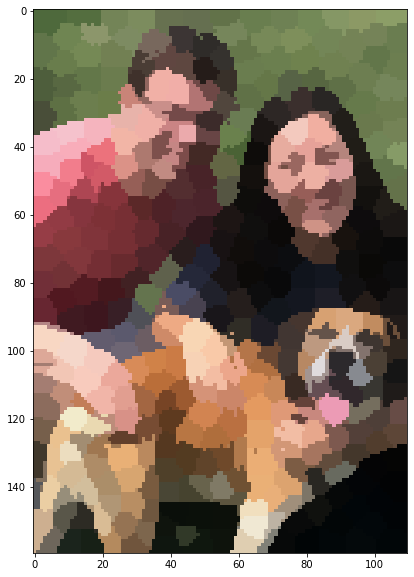

In [15]:
Y = kmeans.cluster_centers_[:, 2:5][kmeans.labels_]
Y = np.reshape(Y, J.shape)
#Y = kmeans.labels_
#Y = np.reshape(Y, (J.shape[0], J.shape[1]))
plt.figure(figsize=(10, 10))
plt.imshow(Y)

To read more about superpixels and their applications, check out <a href = "https://home.ttic.edu/~xren/publication/xren_iccv03_discrim.pdf">the paper that introduced them back in 2003</a>